In [ ]:
#%reset

In [ ]:
#!pip install pmdarima

#### **Introduction to Time Series Forecasting**

A time series is defined as a sequence of data points recorded at various time intervals. The time order can be daily, monthly, or yearly. Forecasting is the process in which we aim to predict the future values that the series will take. We can utilize only the past values of the time series to predict its future values (univariate time series forecasting) or employ external predictors, known as exogenous variables, to forecast it (multivariate time series forecasting).

#### **ARIMA models**

ARIMA stands for Autoregressive **Integrated Moving Average Model**. It is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.
These models are specified by three order parameters (p, d, q) where,

*   p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.
*   q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the model.
*   d is the integration part (I), that is, the number of differencing required to make the time series stationary (constant variance over time).

The SARIMA model is a Seasonal ARIMA and is used when the time series has a seasonal pattern. The model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are the p, d and q of the seasonal part of the data and x is the frequency of the time series.

#### **The Data**

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

In [74]:
df = pd.read_csv('/membership.csv')

In [75]:
df.head()

,date,value
0,2005-07-01,353
1,2005-08-01,318
2,2005-09-01,325
3,2005-10-01,361
4,2005-11-01,357


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    204 non-null    object
 1   value   204 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


In [77]:
df['date'] = pd.to_datetime(df['date'])

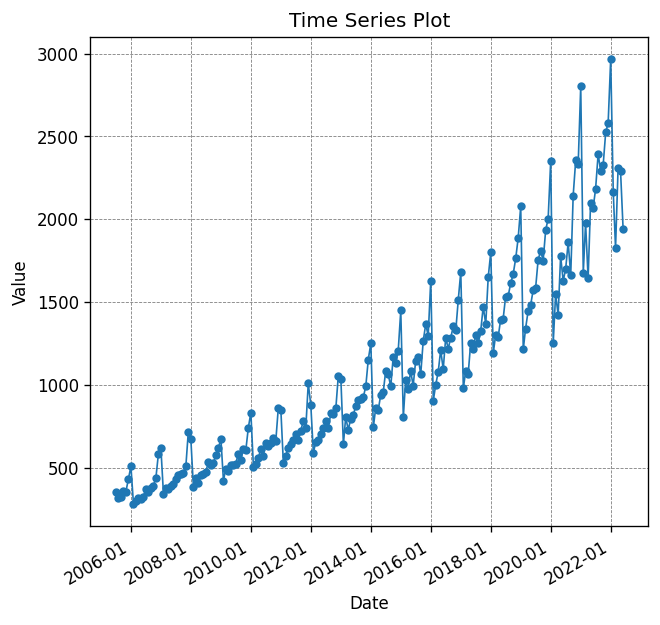

In [78]:
plt.figure(figsize=(6, 6))
plt.plot(df['date'], df['value'], marker='o', markersize=4, linestyle='-', linewidth=1)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Value')

#date ticks
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # Rotation

#grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

plt.grid(True)
plt.show()

As we can observe, there is evident annual seasonality around January. Therefore, for this study, I will be utilizing the univariate SARIMA model method.

#### **The Model**

#### Finding the order of differencing (d)
First, I will check if the series is stationary using the Augmented Dickey Fuller test (ADF Test), from the statsmodels package. The reason being is that we need differencing only if the series is non-stationary. Else, no differencing is needed, that is, d=0.

The null hypothesis (Ho) of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we reject the null hypothesis and infer that the time series is indeed stationary (d=0).
So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [79]:
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.142043
p-value: 1.000000


Since p-value(1.00) is greater than the significance level(0.05), let’s difference the series and see how the autocorrelation plot looks like.

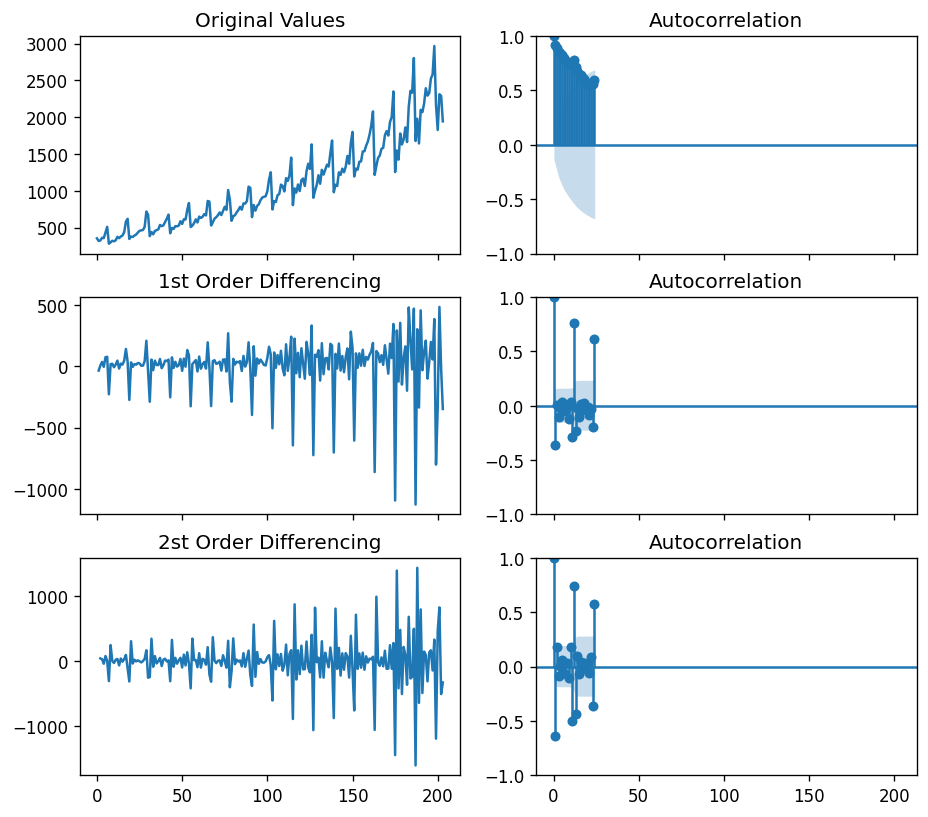

In [80]:
plt.rcParams.update({'figure.figsize':(9,8), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=True)

#original values
axes[0,0].plot(df['value'])
axes[0,0].set_title('Original Values')
plot_acf(df['value'], ax=axes[0,1])

#1st difference
axes[1,0].plot(df['value'].diff())
axes[1,0].set_title('1st Order Differencing')
plot_acf(df['value'].diff().dropna(), ax=axes[1,1])

#2st difference
axes[2,0].plot(df['value'].diff().diff())
axes[2,0].set_title('2st Order Differencing')
plot_acf(df['value'].diff().diff().dropna(), ax=axes[2,1])

plt.show()

For the above data, we can consider that the time series reaches stationarity with one order of differencing. So d=1

#### Fiding the order of the AR term (p)
We will find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot, which can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. This way, we will know if that lag is needed in the AR term or not.

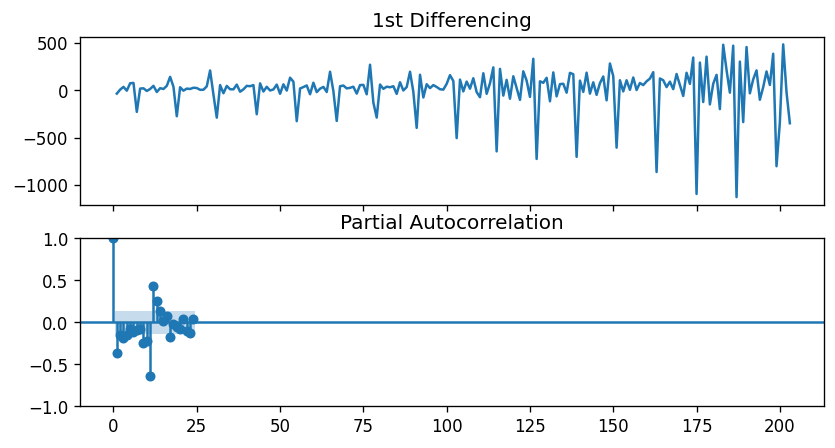

In [81]:
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':120})
fig, axes = plt.subplots(2, 1, sharex=True)

# 1st differencing plot
axes[0].plot(df.value.diff())
axes[0].set_title('1st Differencing')

# PACF plot
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

We can see that the PACF lag 1 is quite significant so, we will fix the value of p = 1.

#### Finding the order of the MA term (q)
Just like how we looked at the PACF plot for the number of AR terms, we will look at the ACF plot for the number of MA terms. An MA term is technically, the error of the lagged forecast.
The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

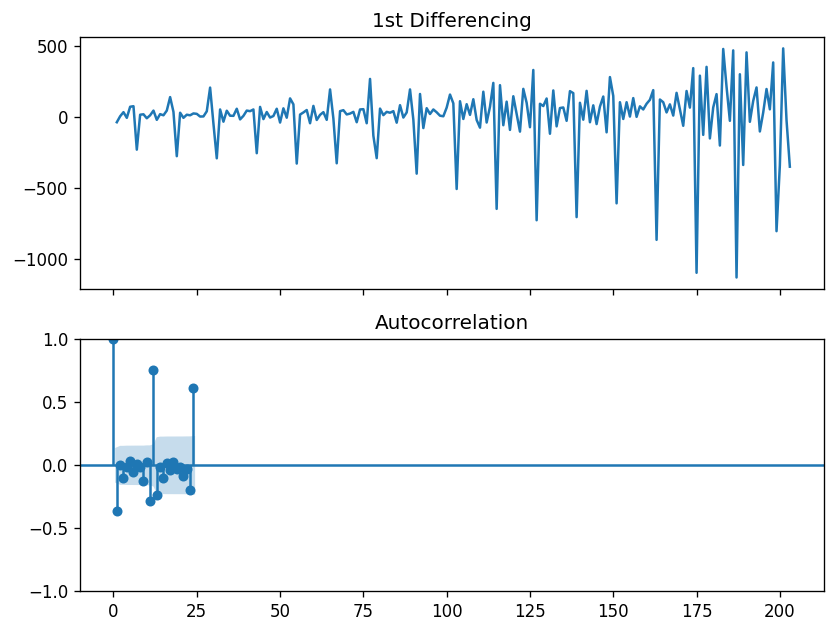

In [82]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 1, sharex=True)

# 1st differencing plot
axes[0].plot(df.value.diff())
axes[0].set_title('1st Differencing')

# PACF plot
axes[1].set(ylim=(0,1.5))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

From this we can set up q=1

So we have (p=1,d=1,q=1)

#### Finding the Seasonal Difference (D)
As our data has a strong and clear seasonal pattern (increasing significantly every January), we can set D=1. We are basically acknowledging that there's a regular seasonal pattern in your data and adjusting your model to account for that pattern. We should try to keep only either SAR or SMA terms if the model has seasonal components.

In [83]:
df['value_diff'] = df['value'].diff().dropna()
seasonal_period = 12
df['value_diff_seasonal'] = df['value_diff'].diff(periods=seasonal_period).dropna()

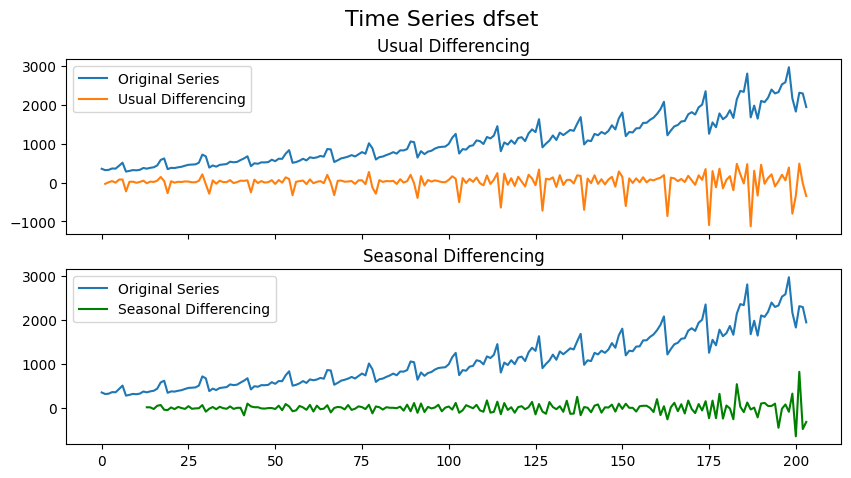

In [139]:
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

#1nd order usual differencing
axes[0].plot(df['value'], label='Original Series')
axes[0].plot(df['value_diff'], label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


#seasonal differencing
axes[1].plot(df['value'], label='Original Series')
axes[1].plot(df['value_diff_seasonal'], label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Time Series dfset', fontsize=16)
plt.show()

#### Finding the Seasonal Autoregressive order (SAR or P)

<Figure size 240x240 with 0 Axes>

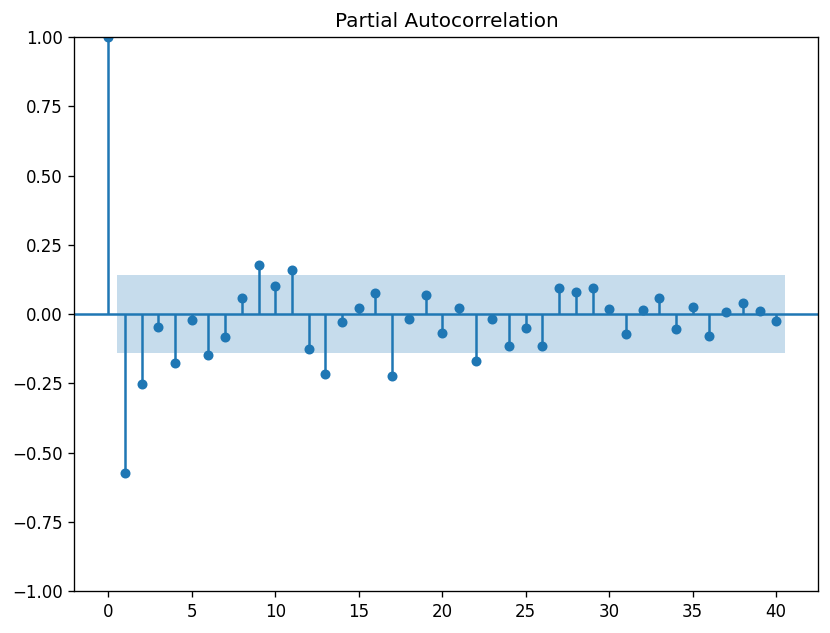

In [88]:
plt.figure(figsize=(2, 2))
plot_pacf(df['value_diff_seasonal'].dropna(), lags=40)
plt.show()

In this plot, there are no significant spikes at the higher lags within the range displayed (up to lag 40). Since we don't see spikes at what would be the expected seasonal lags, we would not necessarily infer a strong seasonal autoregressive component based on this plot alone. Therefore, based on this PACF plot, a P of 0 would be a reasonable starting point for the seasonal autoregressive component of the SARIMA model.

#### Finding the Seasonal Moving Average order (SMA or Q)

<Figure size 240x240 with 0 Axes>

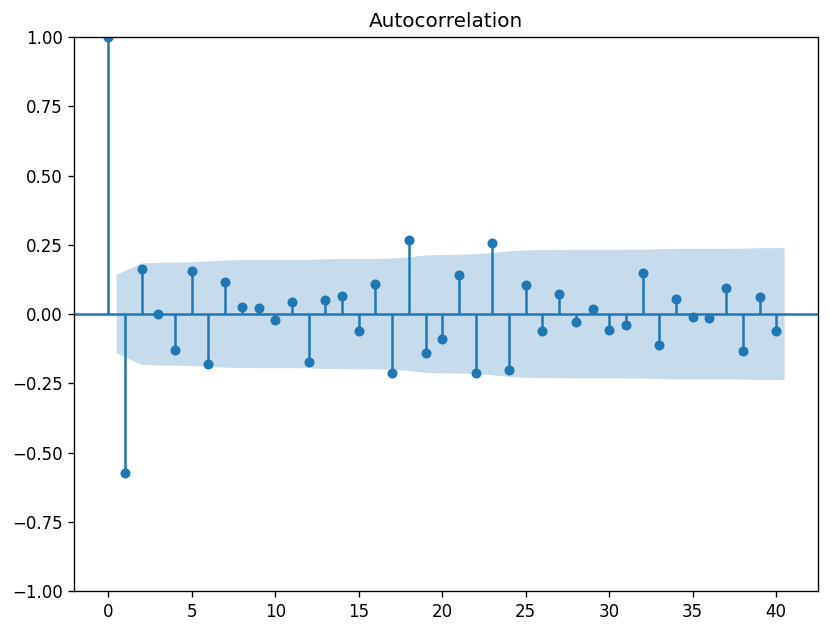

In [89]:
plt.figure(figsize=(2, 2))
plot_acf(df['value_diff_seasonal'].dropna(), lags=40)
plt.show()

There is a significant drop on the first lag, so we can consider Q=1

So now we have our model SARIMA(1,1,1)12(0,1,1).

#### Auto Arima Forecasting in Python

In Python, the pmdarima package provides auto_arima() function which can be used to automate the process of ARIMA Forecastingn. The function uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least Akaike's Information Criterion (AIC), a measure used in statistical modeling to assess the goodness of fit of a model.

When comparing SARIMA models, the model with the lowest AIC is typically considered the best, as it achieves a good balance between explaining the data and avoiding unnecessary complexity.


In [102]:
train = df.value[:142]
test = df.value[142:]

In [106]:
smodel = pm.auto_arima(
    train,
    test='adf',
    start_p=1, start_q=1, start_P=0,
    max_p=3, max_q=3, m=12,
    d=None, D=1,
    seasonal=True,
    information_criterion = 'aic',
    trace=True,
    error_action='ignore', suppress_warnings=True,
)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1382.691, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1470.452, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1423.132, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1384.214, Time=0.82 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1383.951, Time=0.37 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1383.876, Time=1.33 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1383.568, Time=3.57 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1383.423, Time=0.93 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=4.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1421.859, Time=0.33 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1384.333, Time=0.95 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1384.843, Time=0.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1470.228, Time=0.23 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1382.583, Time=0.42 sec
 ARIMA(0,1,2)(0,1,0)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  142
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -687.292
Date:                              Sat, 27 Jan 2024   AIC                           1382.583
Time:                                      18:29:26   BIC                           1394.023
Sample:                                           0   HQIC                          1387.231
                                              - 142                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0279      0.095    -10.863      0.000      -1.213      -0.842
ma.L2          0.1690      0.090      1.883      0.060      -0.007       0.345
ma.S.L12      -0.1991      0.075     -2.649      0.008      -0.346      -0.052
sigma2      2445.6114    250.631      9.758      0.000    1954.383    2936.840
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 7.74
Prob(Q):                              0.92   Prob(JB):                         0.02
Heteroskedasticity (H):               2.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Comparing the models

In [112]:
#fit the auto SARIMA model (0,1,2)(0,1,1)[12] on the training set
auto_sarima = sm.tsa.statespace.SARIMAX(train,
                                               order=(0, 1, 2),
                                               seasonal_order=(0, 1, 1, 12),
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
results_auto_sarima = auto_sarima.fit()

#fit the plot based SARIMA model (1,1,1)(0,1,1)[12] on the training set
plot_sarima = sm.tsa.statespace.SARIMAX(train,
                                               order=(1, 1, 1),
                                               seasonal_order=(0, 1, 1, 12),
                                               enforce_stationarity=False,
                                               enforce_invertibility=False)
results_plot_sarima = plot_sarima.fit()

#forecast on the test set
forecast_auto = results_auto_sarima.get_forecast(steps=len(test))
forecast_plot = results_plot_sarima.get_forecast(steps=len(test))

#get the forecasted values
forecast_auto_values = forecast_auto.predicted_mean
forecast_plot_values = forecast_plot.predicted_mean

#calculate the error metrics for both models
mse_auto = mean_squared_error(test, forecast_auto_values)
rmse_auto = sqrt(mse_auto)

mse_plot = mean_squared_error(test, forecast_plot_values)
rmse_plot = sqrt(mse_plot)

#print the results
print(f"SARIMA(0,1,2)(0,1,1)[12] - MSE: {mse_auto}, RMSE: {rmse_auto}")
print(f"SARIMA(1,1,1)(0,1,1)[12] - MSE: {mse_plot}, RMSE: {rmse_plot}")

#decide which model is better based on lower MSE and RMSE
better_model = 'SARIMA(0,1,2)(0,1,1)[12] auto_sarima' if mse_auto < mse_plot else 'SARIMA(1,1,1)(0,1,1)[12] plot sarima'
print(f"The better model based on MSE is: {better_model}")
better_model = 'SARIMA(0,1,2)(0,1,1)[12] auto_sarima' if rmse_auto < rmse_plot else 'SARIMA(1,1,1)(0,1,1)[12] plot sarima'
print(f"The better model based on RMSE is: {better_model}")


SARIMA(0,1,2)(0,1,1)[12] - MSE: 144792.09389727277, RMSE: 380.51556327865586
SARIMA(1,1,1)(0,1,1)[12] - MSE: 140893.18395916486, RMSE: 375.35740829130424
The better model based on MSE is: SARIMA(1,1,1)(0,1,1)[12] plot sarima
The better model based on RMSE is: SARIMA(1,1,1)(0,1,1)[12] plot sarima


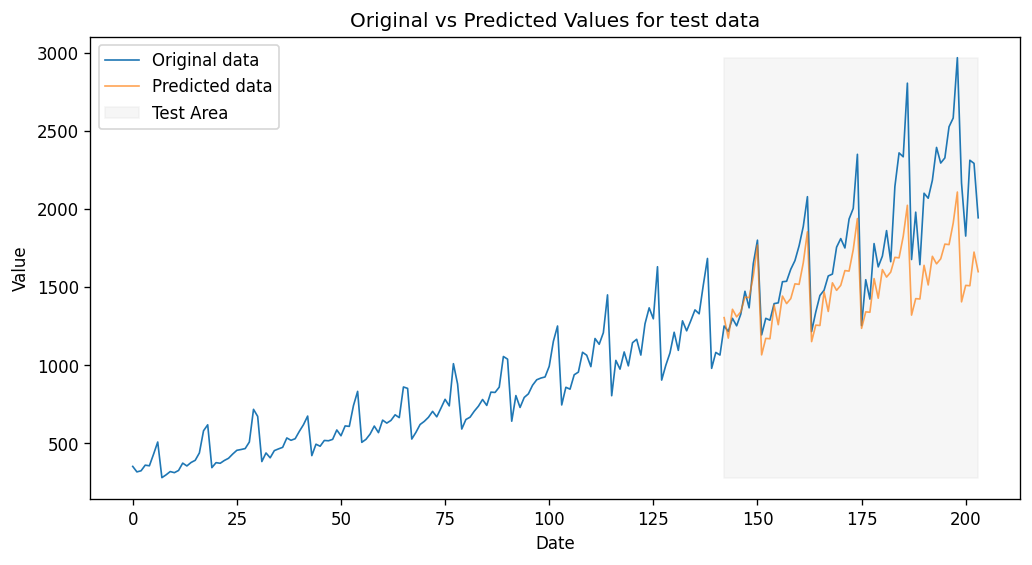

In [131]:
#plot the original values
plt.figure(figsize=(10, 5))
plt.plot(df['value'], label='Original data', linewidth=1)

#plot the combined train and test predictions
plt.plot(forecast_plot_values, label='Predicted data', alpha=0.7, linewidth=1)

#highlight the test area
plt.fill_between(test.index,
                 df['value'].min(),
                 df['value'].max(),
                 color='lightgrey', alpha=0.2, label='Test Area')

plt.title('Original vs Predicted Values for test data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


#### **The Forecast**

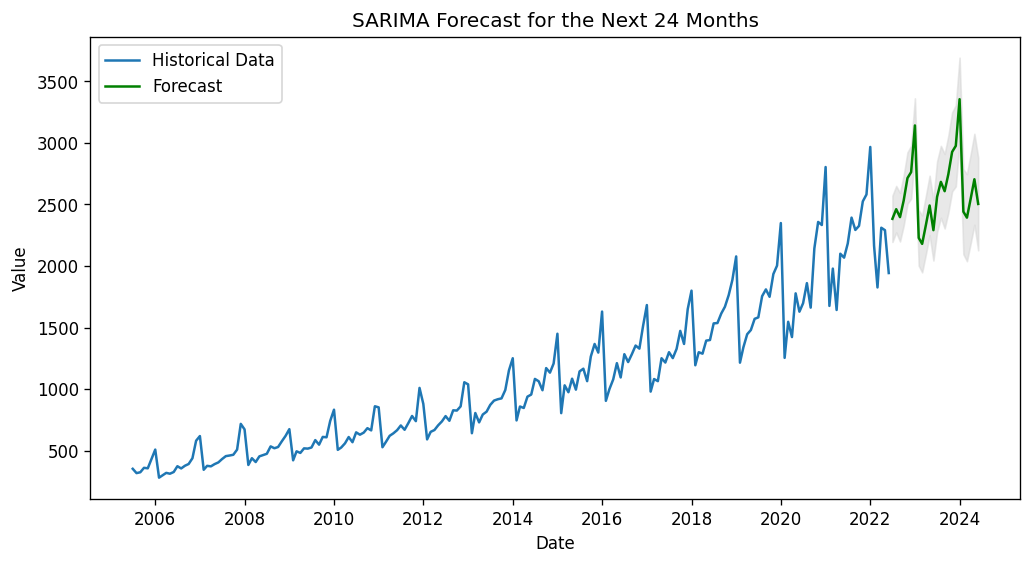

In [132]:
#fit the SARIMA model on the entire dataset
final_model = sm.tsa.statespace.SARIMAX(df['value'],
                                        order=(1, 1, 1),
                                        seasonal_order=(0, 1, 1, 12),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
final_results = final_model.fit()

#forecast the next 24 months
forecast = final_results.get_forecast(steps=24)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

#generate the date range for the forecast
last_date = df['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date, periods=25, freq='MS')[1:]

#plot the historical data and forecast
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['value'], label='Historical Data')
plt.plot(forecast_dates, forecast_values, label='Forecast', color='green')
plt.fill_between(forecast_dates,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgrey', alpha=0.5)
plt.title('SARIMA Forecast for the Next 24 Months')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [138]:
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecasted_Value': round(forecast_values).astype('int')
})

forecast_df

,Date,Forecasted_Value
204,2022-07-01,2383
205,2022-08-01,2462
206,2022-09-01,2397
207,2022-10-01,2531
208,2022-11-01,2714
209,2022-12-01,2763
210,2023-01-01,3142
211,2023-02-01,2228
212,2023-03-01,2180
213,2023-04-01,2335
